# Vineyards

## Numpy code for persistence diagrams computation

In [52]:
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns

In [2]:
def expand_complex(complex):
    if len(complex) == 1:
        return (complex,)
    expansion = []
    expansion.append(tuple(complex))
    for comb in combinations(complex, len(complex)-1):
        expansion.extend(expand_complex(comb))
    return expansion

In [3]:
def filtration(simplex,dist):
    """
    Computes the Vietoris-Rips filtration value of a simplex based on the distance matrix
    Example:
        simplex = (0,2,3)
        dist = NxN distance matrix
    Returns value of the simplex
    """
    if len(simplex)==1:
        return 0
    else:
        if len(simplex)==2:
            return dist[simplex[0],simplex[1]]
        else:
            max = 0
            for comb in combinations(list(simplex),2):
                if dist[comb[0],comb[1]]>max:
                    max = dist[comb[0],comb[1]]
            return max
        
def filtration_all_simplices(simplices, dist):
    """
    Computes the value of all simplices according to a distance matrix
    Input:
    - simplices = list of simplices (e.g. [(0,1),(2,3)])
    - dist = NxN distance matrix
    """
    return [filtration(simplex,dist) for simplex in simplices]

In [4]:
def sort_simplices(simplicial_complex, all_simplices, dist):
    """
    Sort the simplices according to their filtration value

    Input:
    - simplicial complex : the full complex
    - all_simplices: list of all simplices in the complex
    - dist: distance matrix of the points

    Output:
    - sorted_simplices: list of simplices sorted by filtration value
        the ordering is per dimension of simplices (dimension 0 first, then dimension 1, etc.)
    - sorted_values: list of filtration values (in the sorted order)
    """
    sorted_simplices = []
    sorted_values = []
    for d in range(1,1+len(simplicial_complex)):
        d_simplex_vals = [filtration(simplex,dist) for simplex in all_simplices if len(simplex)==d]
        d_simplex = [simplex for simplex in all_simplices if len(simplex)==d]
        sorted_list = sorted(zip(d_simplex_vals,d_simplex))
        sorted_d_simplex = [y for x,y in sorted_list ]
        simplex_vals = [x for x,y in sorted_list]
        sorted_simplices.extend(sorted_d_simplex)
        sorted_values.extend(simplex_vals)
    return sorted_simplices, sorted_values

def get_incidence_matrix(sorted_simplices):
    """
    Compute the incideence matrix from a list of sorted simplices
    """
    D = np.zeros((len(sorted_simplices),len(sorted_simplices)))
    for i in range(len(sorted_simplices)):
        for j in range(i+1,len(sorted_simplices)):
            if len(sorted_simplices[j])==len(sorted_simplices[i])+1:
                if set(sorted_simplices[i]).issubset(set(sorted_simplices[j])):
                    D[i,j] = 1
    return D

In [5]:
def get_low(R,j):
    """
    get the low value of column j for incidence matrix R
    """
    if R[:,j].sum() == 0:
        return None
    else:
        return np.where(R[:,j] != 0)[0][-1]
    
def get_low_sparse(R,j):
    """
    get the low value of column j for incidence matrix R, where R is a list of index of values in each column
    """
    if len(R[j]) == 0:
        return None
    else:
        return R[j][0]
    
def get_all_low(R):
    """
    get the low values of all columns in incidence matrix R
    """
    return np.array([get_low(R,j) for j in range(R.shape[1])])

def reduce_R(D, verbose = False):
    """
    Compute the reduced form of the incidence matrix D.
    """
    R = D.copy()
    V = np.identity(R.shape[0])
    for j in range(R.shape[1]):

        low_j = get_low(R,j)
        
        if verbose:
            print(f"j = {j}")
            print(low_j)
        
        low_other = np.array([get_low(R,i) for i in range(R.shape[1]) if i != j])
        low_idx = np.array([i for i in range(R.shape[1]) if i != j])
        matches = low_idx[np.where(low_other == low_j)[0]]
        matches = matches[matches < j]
        while ((len(matches)>0) and (low_j is not None)):
            if verbose:
                print("matches")
                print(matches)
            R[:,j] = (R[:,j] + R[:,matches[0]]) % 2
            V[matches[0],j] += 1
            low_j = get_low(R,j)
            low_other = np.array([get_low(R,i) for i in range(R.shape[1]) if i != j])
            low_idx = np.array([i for i in range(R.shape[1]) if i != j])
            matches = low_idx[np.where(low_other == low_j)[0]]
            matches = matches[matches < j] 

    from sympy.matrices import Matrix
    U = Matrix(V)
    U = np.array(U.inv_mod(2)).astype(int)
    return R, U

def get_pairs(R):
    lows = [get_low(R,j) for j in range(R.shape[1])]
    pairs = [(lows[j],j) for j in range(len(lows)) if lows[j] is not None]
    essential_pairs = [(j,) for j in range(len(lows)) if (lows[j] is None) and (j not in lows)]

    pairs_all = pairs + essential_pairs

    simplex_ids = [p[-1] for p in pairs_all]
    
    return pairs_all, simplex_ids

def get_pairs_sparse(R):
    lows = [r[-1] if len(r)!=0 else None for r in R]
    pairs = [(lows[j],j) for j in range(len(lows)) if lows[j] is not None]
    lows_set = set(lows)
    essential_pairs = [(j,) for j in range(len(lows)) if (lows[j] is None) and (j not in lows_set)]
    pairs_all = pairs + essential_pairs
    simplex_ids = [p[-1] for p in pairs_all]
    return pairs_all, simplex_ids


def get_persistence_pairs_interval(pairs, dims, filtrations, p = 0, time = 0):
    assert time >= 0
    assert time <= 1
    assert len(filtrations)==2
    
    filtration = filtrations[0] * (1-time) + filtrations[1] * time
    
    persistence_pairs = get_persistence_pairs(pairs,dims, filtration, p = p)
    
    return persistence_pairs

def get_persistence_pairs(pairs,dims, filtration, p = 0):

    persistence_pairs = []
    if p != "all":
        for _, pair in enumerate(pairs):
            if len(pair)==2:
                if dims[pair[0]] ==p:
                    persistence_pairs.append((filtration[pair[0]], filtration[pair[1]]))
            else:
                if dims[pair[0]] ==p:
                    persistence_pairs.append((filtration[pair[0]], np.inf))
    else:
        for _, pair in enumerate(pairs):
            d = dims[pair[0]]
            if len(pair)==2:
                persistence_pairs.append((filtration[pair[0]], filtration[pair[1]],d))
            else:
                persistence_pairs.append((filtration[pair[0]], np.inf, d))

    return persistence_pairs


### Example of persistence diagram computation using the code above

In [6]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

#### OINEUS 

In [126]:
#simplicial_complex = [0,1,2,3,4,5,6]
points = np.random.randn(100,3)
dist = squareform(pdist(points))

In [130]:
fil = oin.get_vr_filtration_from_pwdists(dist, max_dim =2, max_radius = 2, n_threads = 1)

NameError: name 'type_part' is not defined

In [127]:
import numpy as np
import oineus as oin

fil = oin.get_vr_filtration(points, max_dim=2, max_radius=5, n_threads = 1)

dualize = False
dcmp = oin.Decomposition(fil, dualize)

rp = oin.ReductionParams()
rp.compute_u = False
rp.compute_v = True
rp.n_threads = 1
# perform reduction
dcmp.reduce(rp)

In [9]:
sorted_values = [s.value for s in fil.simplices()]
dims= [len(s.vertices)-1 for s in fil.simplices()]
R_ = dcmp.r_data

pairs, simplex_ids = get_pairs_sparse(R_)
persistence_pairs = get_persistence_pairs(pairs,dims, sorted_values, p="all")

#R = np.zeros((len(sorted_values),len(sorted_values)))
#for i in range(len(R_)):
#    R[R_[i],i] = 1

#pairs, _ = get_pairs(R)
#persistence_pairs = get_persistence_pairs(pairs,dims, sorted_values, p="all")
#print(persistence_pairs)

#### MANUAL

In [10]:
### Defining the simplicial complex and the distances 
simplicial_complex = [0,1,2,3]
points = np.random.randn(4,3)
dist = squareform(pdist(points))
#dist = np.abs(np.random.randn(4,4))
#dist = dist - np.diag(np.diag(dist))
#dist = dist + dist.T

all_simplices = list(set(expand_complex(simplicial_complex)))

sorted_simplices, sorted_values = sort_simplices(simplicial_complex, all_simplices, dist)

dims = [len(simplex)-1 for simplex in sorted_simplices]
D = get_incidence_matrix(sorted_simplices)

R,U = reduce_R(D)
pairs, _ = get_pairs(R)
persistence_pairs = get_persistence_pairs(pairs,dims, sorted_values, p="all")
print(persistence_pairs)

[(0, 0.7068419151200613, 0), (0, 0.7487736379021248, 0), (0, 0.913409974251267, 0), (0.8137484126656203, 0.8137484126656203, 1), (1.1600621484973423, 1.1600621484973423, 1), (1.3317894948750966, 1.3317894948750966, 1), (1.3317894948750966, 1.3317894948750966, 2), (0, inf, 0)]


Text(0, 0.5, 'Death')

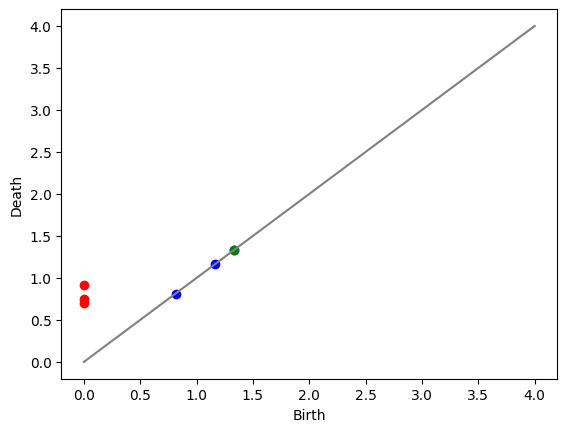

In [11]:
colors_dict = color_dict = {0:"red", 1:"blue", 2:"green", 3:"orange"}
for pairs in persistence_pairs:
    plt.scatter(pairs[0], pairs[1], c=colors_dict[pairs[2]])
plt.plot(np.linspace(0,4),np.linspace(0,4),color= "grey")
plt.xlabel("Birth")
plt.ylabel("Death")

#### Check the results with giotto

In [12]:
from gtda.homology import VietorisRipsPersistence

VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2], metric = 'precomputed')
diagrams = VR.fit_transform(dist[None,...])
diagrams

array([[[0.        , 0.70684189, 0.        ],
        [0.        , 0.74877363, 0.        ],
        [0.        , 0.91340995, 0.        ],
        [0.        , 0.        , 1.        ],
        [0.        , 0.        , 2.        ]]])

## Updating the persistence diagram

In [13]:
def get_crossings(filtration0, filtration1):
    """
    Get the location of the crossings of the persistence diagrams using linear homotopy.

    Inputs:
    - filtration0 : the value of the simplices in the first filtration
    - filtration1 : the value of the simplices in the second filtration
    both should follow the same order of simplices

    Outputs:
    - cross_x : the location of the crossings
    - cross_idx : the index of the simplices that cross
    """
    ps = filtration0
    ms = filtration1 - filtration0

    inter_x = -(ps[None]-ps[:,None]) / (ms[None]-ms[:,None])
    inter_x[np.triu_indices(n=len(inter_x))] = -1
    cross_idx = np.where((inter_x >0)* (inter_x < 1))
    cross_x = inter_x[cross_idx]
    sort_idx = np.argsort(cross_x)
    return cross_x[sort_idx], (cross_idx[0][sort_idx], cross_idx[1][sort_idx])

def permute(R,i,j):
    """
    Permute the rows and columns of the matrix R according to the permutation (i,j)
    """
    R_ = R.copy()
    R_[[i,j]] = R_[[j,i]]
    R_[:,[i,j]] = R_[:,[j,i]]
    return R_

### Example

In [116]:
#distance matrix at time 0
points = np.random.randn(50,3)
dist = squareform(pdist(points))

#distance matrix at time 1
points1 = np.random.randn(50,3)
dist1 = squareform(pdist(points1))

### With oineus

In [117]:
def list_to_str(l):
    return "-".join([str(x) for x in l])

def get_oineus_pairs(points):
    fil = oin.get_vr_filtration(points, max_dim=2, max_radius=5, n_threads = 1)

    dualize = False
    dcmp = oin.Decomposition(fil, dualize )

    rp = oin.ReductionParams()
    rp.compute_u = False
    rp.compute_v = True
    rp.n_threads = 1
    # perform reduction
    dcmp.reduce(rp)

    sorted_values = [s.value for s in fil.simplices()]
    dims= [len(s.vertices)-1 for s in fil.simplices()]
    R_ = dcmp.r_data

    pairs, simplex_ids = get_pairs_sparse(R_)
    persistence_pairs = get_persistence_pairs(pairs,dims, sorted_values, p="all")

    fil_simplices = fil.simplices()
    simplex_vertices_dict = {list_to_str(fil_simplices[s].vertices) : persistence_pairs[i] for i,s in enumerate(simplex_ids)}

    return fil, sorted_values, simplex_vertices_dict #, persistence_pairs, simplex_ids #pairs, simplex_ids, simplex_vertices, persistence_pairs


In [118]:
print("Computing T0")
fil, sorted_values, simplex_vertices_dict0 = get_oineus_pairs(points)

#sorted_values1 = [filtration(simplex.vertices,dist1) for simplex in fil.simplices()]

print("Computing T1")
fil1, _,  simplex_vertices_dict1 = get_oineus_pairs(points1)

dict_list = [simplex_vertices_dict0]
times_list = [0]

vertices_uniques = set(simplex_vertices_dict0.keys())

x_cross = np.linspace(0,1,10)
for x_ in tqdm.tqdm(x_cross):
    points_ = points * (1-x_) + points1 * x_
    _, _,  simplex_vertices_dict_ = get_oineus_pairs(points_)
    dict_list.append(simplex_vertices_dict_)
    times_list.append(x_)
    vertices_uniques = vertices_uniques.union(set(simplex_vertices_dict_.keys()))

dict_list.append(simplex_vertices_dict1)
vertices_uniques = vertices_uniques.union(set(simplex_vertices_dict1.keys()))
times_list.append(1)

Computing T0
Computing T1


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


In [252]:
#dict_list = [simplex_vertices_dict0]
#times_list = [0]

#vertices_uniques = set(simplex_vertices_dict0.keys())

#for x_ in x_cross:
#    points_ = points * (1-x_) + points1 * x_
#    _, _,  simplex_vertices_dict_ = get_oineus_pairs(points_)
#    dict_list.append(simplex_vertices_dict_)
#    times_list.append(x_)
#    vertices_uniques = vertices_uniques.union(set(simplex_vertices_dict_.keys()))

#dict_list.append(simplex_vertices_dict1)
#vertices_uniques = vertices_uniques.union(set(simplex_vertices_dict1.keys()))
#times_list.append(1)

In [119]:
base_dict = {k:[] for k in vertices_uniques}

for k in base_dict.keys():
    for t_, dict_ in enumerate(dict_list):
        base_dict[k].append((times_list[t_],) + dict_.get(k,(None,)))

In [120]:
### Getting the simplices with highest persistence at time 0

persistence_t0_dim0 = { k: v[1]-v[0] for k,v in simplex_vertices_dict0.items() if v[2] == 0 }
persistence_t0_dim1 = { k: v[1]-v[0] for k,v in simplex_vertices_dict0.items() if v[2] == 1 }

## SHow the 10 first simplices with highest persistence
sorted_dim0 = sorted(persistence_t0_dim0.items(), key=lambda item: item[1], reverse=True)
sorted_dim1 = sorted(persistence_t0_dim1.items(), key=lambda item: item[1], reverse=True)
best_names_dim0 = [x[0] for x in sorted_dim0[:10]]
best_names_dim1 = [x[0] for x in sorted_dim1[:10]]

print(best_names_dim0)

['0', '33-37', '35-42', '42-49', '21-38', '21-35', '24-36', '16-23', '22-48', '2-16']


In [121]:
def plot_vineyards(simplex_id, base_dict, marker_dict, color_dict, legend_elements, max_value = 5, dim_p = 0):
    ### Max value if the value plotted if the persistence is infinite

    if not isinstance(simplex_id,list):
        simplex_id = [simplex_id]

    fig,ax = plt.subplots()
    
    for i_s, s_id in enumerate(simplex_id):
        
        if type(s_id) == int:
            simplex_name = list(base_dict.keys())[s_id]
        else:
            simplex_name = s_id
        simplex = base_dict[simplex_name]
        x = []
        y = []
        dim = []
        t = []
        p = []
        c = []
        
        for step in range(len(simplex)):

            if simplex[step][1] is None:
                continue
            dim_ = simplex[step][3]
            if dim_ != dim_p:
                continue
            t.append(simplex[step][0])
            x.append(simplex[step][1])
            y.append(simplex[step][2])
            p.append(y[-1] - x[-1])
            if np.isinf(p[-1]):
                p[-1] = max_value
            c.append(len(simplex_name.split('-')))
            dim.append(simplex[step][3])
            ax.scatter(t[-1], p[-1], c= color_dict[i_s], marker = marker_dict[dim[-1]])
        ax.plot(t,p, c = color_dict[i_s])
    ax.set_xlabel("Time")
    ax.set_ylabel("Persistence")
    ax.legend(handles=legend_elements, loc='upper right',bbox_to_anchor=(1.5, 1.))

/var/folders/mt/chc1ffgd6vbcj65ckwqbppw80000gn/T/ipykernel_19201/2537307251.py:38: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(t[-1], p[-1], c= color_dict[i_s], marker = marker_dict[dim[-1]])


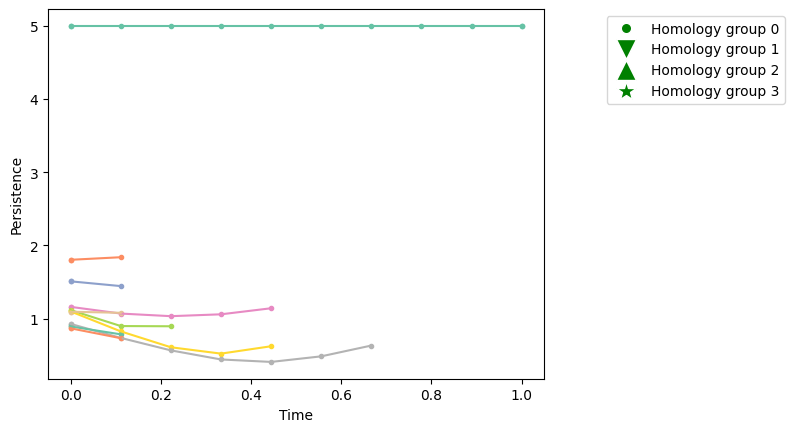

In [123]:
marker_dict = {0:".", 1:"v", 2:"^", 3:"*"}
color_dict = sns.color_palette("Set2", 10)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements =  [Line2D([0], [0], marker=c, color="w", label=f'Homology group {l}',
                          markerfacecolor='g', markersize=15) for l,c in marker_dict.items()]


plot_vineyards(best_names_dim0,base_dict, marker_dict = marker_dict, color_dict=color_dict, legend_elements = legend_elements, dim_p = 0)

### With homemade code

In [66]:
import numpy as np

### Defining the simplicial complex and the distances 
simplicial_complex = [0,1,2,3]

all_simplices = list(set(expand_complex(simplicial_complex)))

sorted_simplices, sorted_values = sort_simplices(simplicial_complex, all_simplices, dist)
sorted_simplices1, sorted_values__1 = sort_simplices(simplicial_complex, all_simplices, dist1) 
sorted_values1 = filtration_all_simplices(sorted_simplices, dist1)

dims = [len(simplex)-1 for simplex in sorted_simplices]
D = get_incidence_matrix(sorted_simplices)

# Reduced incidence matrix at time 0 
R,U = reduce_R(D)
pairs, simplex_ids = get_pairs(R)
persistence_pairs = get_persistence_pairs(pairs,dims, sorted_values, p="all")


# Updating the incidence matrix
t = 1
x_cross, cross_idx = get_crossings(np.array(sorted_values),np.array(sorted_values1))

cross_i_before_t = [idx for idx in range(len(x_cross)) if x_cross[idx]<=t]
cross_idx_before_t = [(cross_idx[0][i], cross_idx[1][i]) for i in cross_i_before_t]
cross_x_before_t = [x_cross[idx] for idx in cross_i_before_t]

# keeping track of the location of the simplices in the t=0 ordering
simplex_location = [i for i in range(len(sorted_values))]

D_updated = D.copy()

persistences = [persistence_pairs]
simplex_ids = [simplex_ids]
times = [0]

for idx in range(len(cross_i_before_t)):
    times.append(cross_x_before_t[idx])
    simplex_0, simplex_1 = cross_idx_before_t[idx]
    swap_idx_unsorted = (simplex_location[simplex_0],simplex_location[simplex_1])
    swap_idx = sorted(swap_idx_unsorted)
    i = swap_idx[0]
    j = swap_idx[1]

    if dims[i] != dims[j]:
        print("DIM MISMATCH !")
        continue
    else:
        simplex_location[simplex_0] = swap_idx_unsorted[1]
        simplex_location[simplex_1] = swap_idx_unsorted[0]
        D_updated = permute(D_updated,i,j)

    reverse_loc = np.argsort(simplex_location)

    R_updated, _ = reduce_R(D_updated)
    pairs_updated, simplex_ids_updated = get_pairs(R_updated)

    simplex_id_updated = [reverse_loc[v] for v in simplex_ids_updated]

    sorted_values_t = np.array(sorted_values) * (1-t) + np.array(sorted_values1) * t # linear interpolation of the filtration values at time t according to old ordering

    sorted_values_t_updated = [sorted_values_t[v] for v in reverse_loc] # from old order to new order

    persistence_pairs_updated = get_persistence_pairs(pairs_updated,dims, sorted_values_t_updated, p="all")
    print(persistence_pairs_updated)

    persistences.append(persistence_pairs_updated)
    simplex_ids.append(simplex_id_updated)

/var/folders/mt/chc1ffgd6vbcj65ckwqbppw80000gn/T/ipykernel_19201/2332822541.py:17: RuntimeWarning: invalid value encountered in divide
  inter_x = -(ps[None]-ps[:,None]) / (ms[None]-ms[:,None])


[(0.0, 1.4601478220376374, 0), (0.0, 2.370474198350698, 0), (0.0, 1.375806504863964, 0), (2.235990242057653, 2.235990242057653, 1), (2.539299514989015, 2.539299514989015, 1), (2.418951342823015, 2.418951342823015, 1), (2.539299514989015, 2.539299514989015, 2), (0.0, inf, 0)]
[(0.0, 1.4601478220376374, 0), (0.0, 1.375806504863964, 0), (0.0, 2.370474198350698, 0), (2.235990242057653, 2.235990242057653, 1), (2.539299514989015, 2.539299514989015, 1), (2.418951342823015, 2.418951342823015, 1), (2.539299514989015, 2.539299514989015, 2), (0.0, inf, 0)]
[(0.0, 1.4601478220376374, 0), (0.0, 1.375806504863964, 0), (0.0, 2.370474198350698, 0), (2.235990242057653, 2.235990242057653, 1), (2.539299514989015, 2.539299514989015, 1), (2.418951342823015, 2.418951342823015, 1), (2.539299514989015, 2.539299514989015, 2), (0.0, inf, 0)]
[(0.0, 1.4601478220376374, 0), (0.0, 1.375806504863964, 0), (0.0, 2.370474198350698, 0), (2.235990242057653, 2.235990242057653, 1), (2.539299514989015, 2.539299514989015, 1

In [89]:
all_simplices

[(0, 1),
 (1, 3),
 (0,),
 (2,),
 (1, 2),
 (0, 1, 3),
 (0, 3),
 (0, 2, 3),
 (1, 2, 3),
 (2, 3),
 (1,),
 (0, 2),
 (0, 1, 2, 3),
 (0, 1, 2),
 (3,)]

In [67]:
persistence_pairs_updated = get_persistence_pairs(pairs_updated,dims, sorted_values_t_updated, p=0)
print(persistence_pairs_updated)

[(0.0, 1.375806504863964), (0.0, 1.4601478220376374), (0.0, 2.370474198350698), (0.0, inf)]


#### Verification with giotto-tda

In [95]:
from gtda.homology import VietorisRipsPersistence

VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2], metric = 'precomputed')
diagrams = VR.fit_transform(dist1[None,...])
diagrams

array([[[0.        , 1.18103933, 0.        ],
        [0.        , 1.30159438, 0.        ],
        [0.        , 1.31818688, 0.        ],
        [0.        , 1.53285301, 0.        ],
        [0.        , 3.26199508, 0.        ],
        [3.3476541 , 3.38241506, 1.        ],
        [0.        , 0.        , 2.        ]]])

In [93]:
dist1

array([[0.        , 2.23599024, 2.3704742 , 1.46014782],
       [2.23599024, 0.        , 2.41895134, 1.3758065 ],
       [2.3704742 , 2.41895134, 0.        , 2.53929951],
       [1.46014782, 1.3758065 , 2.53929951, 0.        ]])

Text(0, 0.5, 'Simplex value')

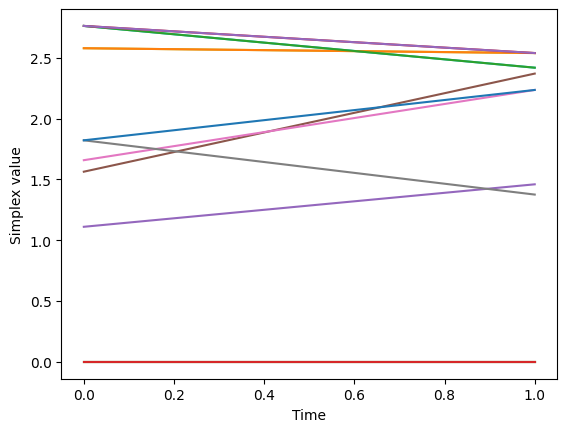

In [69]:
plt.plot(np.stack((sorted_values,sorted_values1)))
plt.xlabel("Time")
plt.ylabel("Simplex value")

### Plotting the vineyards

In [78]:
marker_dict = {0:".", 1:"v", 2:"^", 3:"*"}
color_dict = {0:"red", 1:"blue", 2:"green", 3:"orange"}

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [ Line2D([0], [0], color=c, label=f"Simplex dimension : {l}") for l,c in color_dict.items()]
legend_elements = legend_elements + [Line2D([0], [0], marker=c, color="w", label=f'Homology group {l}',
                          markerfacecolor='g', markersize=15) for l,c in marker_dict.items()]

def plot_persistence_over_time(simplex_id, simplex_ids,persistences, marker_dict, color_dict, legend_elements):
    fig,ax = plt.subplots()
    if not isinstance(simplex_id,list):
        simplex_id = [simplex_id]
    
    for s_id in simplex_id:
        x = []
        y = []
        c = []
        for step in range(len(simplex_ids)):
            id_ = np.where(np.array(simplex_ids[step])== s_id)[0]
            if len(id_)==0:
                continue
            else:
                id = id_.item()
            x.append(persistences[step][id][0])
            y.append(persistences[step][id][1])
            c.append(persistences[step][id][2])
            ax.scatter(x[-1], y[-1], c= color_dict[c[-1]], marker = marker_dict[dims[s_id]])

        if np.unique(c).size == 1:
            ax.plot(x, y, c = color_dict[c[0]])
        else:
            ax.plot(x, y, c = "grey")

        ax.plot(np.linspace(0,4),np.linspace(0,4), linestyle = "--", c = "grey")
        ax.set_xlabel("Birth")
        ax.set_ylabel("Death")
        ax.legend(handles=legend_elements, loc='lower right')

def plot_vineyards(simplex_id, simplex_ids,persistences, marker_dict, color_dict, legend_elements):

    if not isinstance(simplex_id,list):
        simplex_id = [simplex_id]

    fig,ax = plt.subplots()
    
    for s_id in simplex_id:
        x = []
        y = []
        c = []
        t = []
        p = []
        for step in range(len(simplex_ids)):
            id_ = np.where(np.array(simplex_ids[step])== s_id)[0]
            if len(id_)==0:
                continue
            else:
                id = id_.item()
            t.append(times[step])
            x.append(persistences[step][id][0])
            y.append(persistences[step][id][1])
            p.append(y[-1] - x[-1])
            c.append(persistences[step][id][2])
            ax.scatter(t[-1], p[-1], c= color_dict[c[-1]], marker = marker_dict[dims[s_id]])

        ax.plot(t,p, c = "grey")
    ax.set_xlabel("Time")
    ax.set_ylabel("Persistence")
    ax.legend(handles=legend_elements, loc='upper right',bbox_to_anchor=(1.5, 1.))


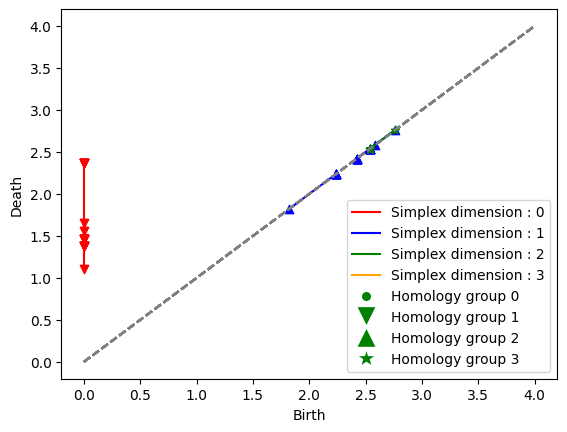

In [79]:
plot_persistence_over_time([i for i in range(len(all_simplices))], simplex_ids,persistences, marker_dict, color_dict, legend_elements)

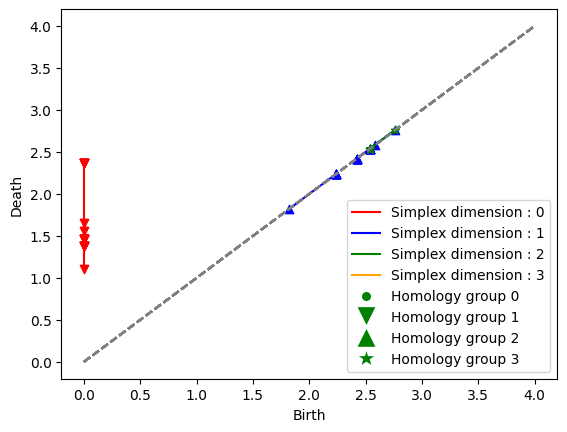

In [73]:
plot_persistence_over_time([i for i in range(len(all_simplices))], simplex_ids,persistences, marker_dict, color_dict, legend_elements)

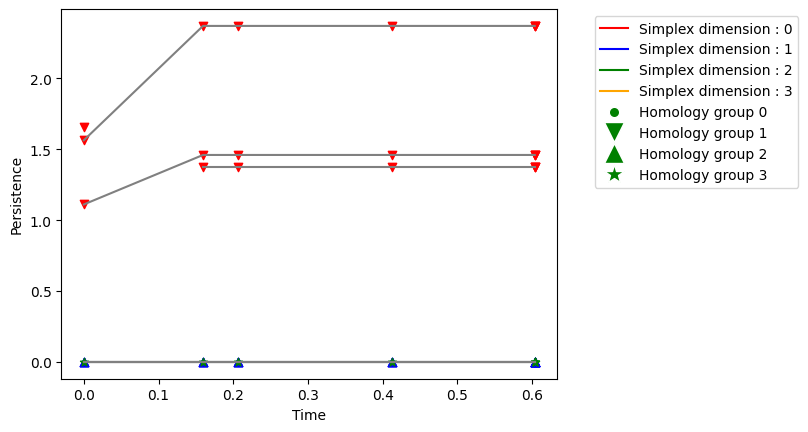

In [80]:
plot_vineyards([i for i in range(len(all_simplices))], simplex_ids,persistences, marker_dict, color_dict, legend_elements)

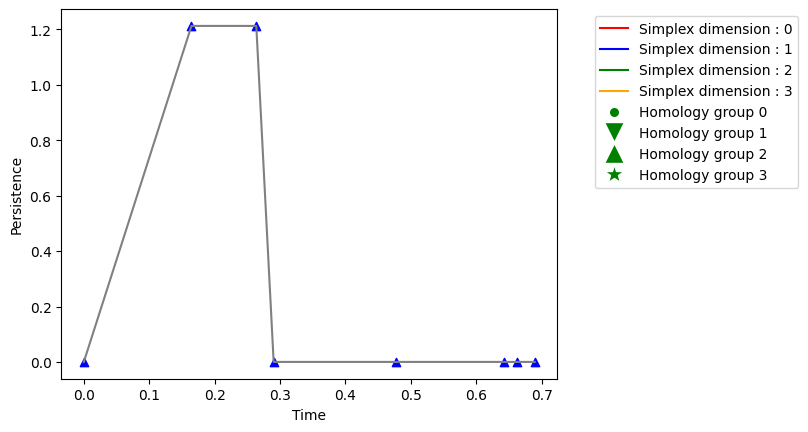

In [23]:
plot_vineyards([11], simplex_ids,persistences, marker_dict, color_dict, legend_elements)

## Speeding up the updating of the persistence diagram

In [287]:
def process_permutations(R,U,i,j):
    """
    Process the permutations of the matrix R and U according to the permutation (i,j)
    """
    assert j == i+1

    all_lows = get_all_low(R)
    if (get_low(R,i) is None) and (get_low(R,j) is None):
        print("Case 1")
        R,U = case_1(R,U,i,j)
    elif (get_low(R,i) is not None) and (get_low(R,j) is not None):
        print("Case 2")
        R,U = case_2(R,U,i,j)
    elif (get_low(R,i) is not None) and (get_low(R,j) is None):
        print("Case 3")
        R,U = case_3(R,U,i,j)
    elif (get_low(R,i) is None) and (get_low(R,j) is not None):
        print("Case 4")
        R, U = case_4(R,U,i,j)

    return R, U


def case_1(R,U,i,j):
    R_ = R.copy()
    U_ = U.copy()
    all_lows = get_all_low(R_)
    #Case 1.1
    if (i in all_lows) and (j in all_lows):
        print("case 1.1")
        k = np.where(all_lows == i)[0][0]
        l = np.where(all_lows == j)[0][0]
        if R_[i,l] == 1:
            if k<l: #Case 1.1.1
                R_ = permute(R_,i,j)
                U_ = permute(U_,i,j)
                R_[:,l] = (R_[:,l] + R_[:,k]) % 2
                U_[l,:] = (U_[l,:] + U_[k,:]) % 2
            elif k>l: #Case 1.1.2
                R_ = permute(R_,i,j)
                U_ = permute(U_,i,j)
                R_[:,k] = (R_[:,k] + R_[:,l]) % 2
                U_[k,:] = (U_[k,:] + U_[l,:]) % 2
    else:
        print("case 1.2")
        R_ = permute(R_,i,j)
        U_ = permute(U_,i,j)
    return R_, U_

def case_2(R,U,i,j):
    #Case 2
    #Check if position of negative simplices.
    R_ = R.copy()
    U_ = U.copy()
    if U_[i,j] == 1:
        U_[j,:] = (U_[j,:] + U_[i,:]) % 2
        R_[:,j] = (R_[:,j] + R_[:,i]) % 2
        if get_low(R_,i) < get_low(R_,j):
            R_ = permute(R_,i,j)
            U_ = permute(U_,i,j)
        elif get_low(R_,i) > get_low(R_,j):
            R_ = permute(R_,i,j)
            U_ = permute(U_,i,j)
            R_[:,j] = (R_[:,j] + R_[:,i]) % 2
            U_[j,:] = (U_[j,:] + U_[i,:]) % 2
    else:
        R_ = permute(R_,i,j)
        U_ = permute(U_,i,j)
    return R_, U_

def case_3(R,U,i,j):
    R_ = R.copy()
    U_ = U.copy()
    if U_[i,j] == 1:
        U_[j,:] = (U_[j,:] + U_[i,:]) % 2
        R_[:,j] = (R_[:,j] + R_[:,i]) % 2
        U_ = permute(U_,i,j)
        R_ = permute(R_,i,j)
        U_[j,:] = (U_[j,:] + U_[i,:]) % 2
        R_[:,j] = (R_[:,j] + R_[:,i]) % 2
    else:
        R_ = permute(R_,i,j)
        U_ = permute(U_,i,j)
    return R_, U_

def case_4(R,U,i,j):
    #Case 4
    R_ = R.copy()
    U_ = U.copy()
    
    if U_[i,j] == 1:
        U_[i,j] = 0
    
    R_ = permute(R_,i,j)
    U_ = permute(U_,i,j)
    return R_, U_      

### Example usage

In [290]:
import numpy as np

### Defining the simplicial complex and the distances 
simplicial_complex = [0,1,2,3]

#distance matrix at time 0
dist = np.abs(np.random.randn(4,4))
dist = dist - np.diag(np.diag(dist))
dist = dist + dist.T

#distance matrix at time 1
dist1 = np.abs(np.random.randn(4,4))
dist1 = dist1 - np.diag(np.diag(dist1))
dist1 = dist1 + dist1.T


all_simplices = list(set(expand_complex(simplicial_complex)))

sorted_simplices, sorted_values = sort_simplices(simplicial_complex, all_simplices, dist)
sorted_values1 = filtration_all_simplices(sorted_simplices, dist1)

dims = [len(simplex)-1 for simplex in sorted_simplices]
D = get_incidence_matrix(sorted_simplices)

# Reduced incidence matrix at time 0 
R,U = reduce_R(D)
pairs = get_pairs(R)
persistence_pairs = get_persistence_pairs(pairs,dims, sorted_values, p=0)


# Updating the incidence matrix
t = 1
x_cross, cross_idx = get_crossings(np.array(sorted_values),np.array(sorted_values1))

cross_i_before_t = [idx for idx in range(len(x_cross)) if x_cross[idx]<t]
cross_idx_before_t = [(cross_idx[0][i], cross_idx[1][i]) for i in cross_i_before_t]
cross_x_before_t = [x_cross[idx] for idx in cross_i_before_t]

# keeping track of the location of the simplices in the t=0 ordering
simplex_location = {i: i for i in range(len(sorted_values))}

for idx in range(len(cross_i_before_t)):
    simplex_0, simplex_1 = cross_idx_before_t[idx]
    swap_idx_unsorted = (simplex_location[simplex_0],simplex_location[simplex_1])
    swap_idx = sorted(swap_idx)
    i = swap_idx[0]
    j = swap_idx[1]
    if np.abs(i-j) > 1:
        continue
    else:
        simplex_location[simplex_0] = swap_idx_unsorted[1]
        simplex_location[simplex_1] = swap_idx_unsorted[0]
        R_updated, U_updated = process_permutations(R,U,i, j) 
        print("PERMUTATION NEEDED")

pairs_updated = get_pairs(R_updated)

new_idx = np.array([v for k,v in simplex_location.items()]).astype(int)
old_idx = np.array([k for k,v in simplex_location.items()]).astype(int)

sorted_values_t = sorted_values * (1-t) + sorted_values1 * t # linear interpolation of the filtration values at time t according to old ordering
sorted_values_t_updated = np.zeros(len(sorted_values_t)) 
sorted_values_t_updated[new_idx] = np.array(sorted_values_t)[old_idx] # linear interpolation in the new ordering

persistence_pairs_updated = get_persistence_pairs(pairs_updated,dims, sorted_values_t_updated, p=0)
print(persistence_pairs_updated)


Case 1
case 1.1
PERMUTATION NEEDED
Case 1
case 1.1
PERMUTATION NEEDED
Case 1
case 1.1
PERMUTATION NEEDED
Case 1
case 1.1
PERMUTATION NEEDED
Case 1
case 1.1
PERMUTATION NEEDED
Case 1
case 1.1
PERMUTATION NEEDED
Case 1
case 1.1
PERMUTATION NEEDED
Case 1
case 1.1
PERMUTATION NEEDED
Case 1
case 1.1
PERMUTATION NEEDED
Case 1
case 1.1
PERMUTATION NEEDED
Case 1
case 1.1
PERMUTATION NEEDED
Case 1
case 1.1
PERMUTATION NEEDED
Case 1
case 1.1
PERMUTATION NEEDED
Case 1
case 1.1
PERMUTATION NEEDED
Case 1
case 1.1
PERMUTATION NEEDED
Case 1
case 1.1
PERMUTATION NEEDED
[(0.0, 0.9429362457043322), (0.0, 1.3417782953996293), (0.0, 2.0198320904109592), (0.0, inf)]


/var/folders/mt/chc1ffgd6vbcj65ckwqbppw80000gn/T/ipykernel_69201/1029456987.py:17: RuntimeWarning: invalid value encountered in divide
  inter_x = -(ps[None]-ps[:,None]) / (ms[None]-ms[:,None])


#### Verification with giotto-tda

In [291]:
from gtda.homology import VietorisRipsPersistence

VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2], metric = 'precomputed')
diagrams = VR.fit_transform(dist1[None,...])
diagrams

array([[[0.        , 0.94293624, 0.        ],
        [0.        , 1.34177828, 0.        ],
        [0.        , 2.01983213, 0.        ],
        [0.        , 0.        , 1.        ],
        [0.        , 0.        , 2.        ]]])